#ASL-alphabet Detection project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import mediapipe as mp
import os
import cv2
import re
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#To import data and train on colab

# ! pip install -q kaggle
# import os
# from google.colab import files
# files.upload()

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download -d grassknoted/asl-alphabet
# ! mkdir asl_alphabet
# ! unzip asl-alphabet.zip -d asl_alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alp

In [13]:
# Initialize Mediapipe Hand solution
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

In [14]:
def extract_features(image_path):
    """
    Extracts hand keypoint features from an image using Mediapipe.
    Returns a flattened list of x, y, and z coordinates if a hand is detected; otherwise, returns None.
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Convert image to RGB for Mediapipe processing
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    # Check if a hand was detected in the image
    if results.multi_hand_landmarks:
        # Extract features: x, y, z coordinates of each key point
        landmarks = results.multi_hand_landmarks[0].landmark
        features = [coord for lm in landmarks for coord in (lm.x, lm.y, lm.z)]
        return features
    else:
        print(f"Warning: No hand detected in image at {image_path}")
        return None

In [15]:
def prepare_train_dataset(dataset_path, max_images_per_label=200):
    """
    Prepares the training dataset by extracting features for up to `max_images_per_label` images
    in each folder corresponding to a label.
    Returns a DataFrame with extracted features and their labels.
    """
    data = []
    labels = []
    failed_images = []

    # Iterate through each label folder in the dataset
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue

        print(f"Processing label '{label}'...")

        # Get list of images
        image_files = os.listdir(label_path)

        # Process images until we have the desired number of valid samples for this label
        image_count = 0
        for image_name in image_files:
            if image_count >= max_images_per_label:
                break  # Stop if we've collected enough images for this label

            image_path = os.path.join(label_path, image_name)

            # Extract features for each image
            features = extract_features(image_path)
            if features:
                data.append(features)
                labels.append(label)
                image_count += 1  # Increment count only if features were successfully extracted
            else:
                failed_images.append(image_path)

    # Convert lists to DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels

    # Log failed images for review
    if failed_images:
        print(f"\nFailed to process {len(failed_images)} images.")
        for failed_image in failed_images:
            print(f"  - {failed_image}")

    return df

def prepare_test_dataset(test_folder_path):
    """
    Prepares the test dataset by extracting features from each image in a single folder and inferring labels from filenames.
    Returns a DataFrame with extracted features and their labels.
    """
    data = []
    labels = []
    failed_images = []

    # Regex to extract label from filename (e.g., "A_test.jpg" -> "A")
    label_pattern = re.compile(r'([a-zA-Z]+)_test')

    # Process each image in the test folder
    for image_name in os.listdir(test_folder_path):
        image_path = os.path.join(test_folder_path, image_name)

        # Extract label from filename
        match = label_pattern.match(image_name)
        if not match:
            print(f"Warning: Unable to extract label from {image_name}")
            continue
        label = match.group(1).upper()  # Standardize to uppercase for consistency

        # Extract features
        features = extract_features(image_path)
        if features:
            data.append(features)
            labels.append(label)
        else:
            failed_images.append(image_path)

    # Convert lists to DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels

    # Log failed images for review
    if failed_images:
        print(f"\nFailed to process {len(failed_images)} images.")
        for failed_image in failed_images:
            print(f"  - {failed_image}")

    return df

In [ ]:
train_path = '/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train'
test_path = '/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test'

# Prepare the training and testing datasets
print("Preparing training data...")
train_df = prepare_train_dataset(train_path, max_images_per_label=200)
print("\nPreparing testing data...")
test_df = prepare_test_dataset(test_path)

# Perform data checks
print("\nTraining data sample:")
print(train_df.head())
print("\nTesting data sample:")
print(test_df.head())

# Check for any missing or incomplete rows in the dataset
print("\nData Check - Missing Values:")
print(train_df.isnull().sum())
print(test_df.isnull().sum())

Streaming output truncated to the last 5000 lines.
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O474.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2556.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O466.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2927.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2188.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2916.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2162.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2353.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O481.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2575.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2160.jpg
  - /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/O/O2791.jpg
  - /content/asl_alphabet/asl_alphabet_t

In [ ]:
train_df.groupby('label').count()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
label,,,,,,,,,,,,,,,,,,,,,
A,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
B,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
C,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
D,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
E,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
F,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
G,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
H,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
I,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200


In [16]:
train_df = pd.read_csv("train_asl.csv")

In [17]:
train_df.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', 'label'],
      dtype='object')

In [18]:
train_df.drop(["Unnamed: 0"], axis = 1, inplace=True)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,label
0,0.261519,0.867270,8.150708e-07,0.310741,0.828865,-0.038462,0.321165,0.755122,-0.050184,0.263509,...,0.178255,0.679419,-0.074051,0.193717,0.714214,-0.080735,0.208883,0.749601,-0.079449,W
1,0.802133,0.763140,1.158311e-06,0.888572,0.724003,-0.061827,0.919095,0.617901,-0.076430,0.840509,...,0.744712,0.491074,-0.121970,0.767070,0.544600,-0.141254,0.781524,0.600390,-0.145109,W
2,0.589166,0.940886,1.214212e-06,0.652449,0.935167,-0.053427,0.696626,0.878923,-0.074253,0.647716,...,0.554613,0.725227,-0.109468,0.565791,0.767524,-0.112448,0.569495,0.814629,-0.107372,W
3,0.321133,0.896692,9.575349e-07,0.389772,0.843667,-0.049963,0.416919,0.746017,-0.060290,0.346302,...,0.247526,0.655560,-0.085440,0.274085,0.691696,-0.098987,0.286639,0.739091,-0.102423,W
4,0.219679,0.804368,1.291535e-06,0.302003,0.781448,-0.070728,0.340822,0.675492,-0.091664,0.252662,...,0.152973,0.545658,-0.128545,0.170165,0.606101,-0.139406,0.179465,0.658248,-0.135550,W


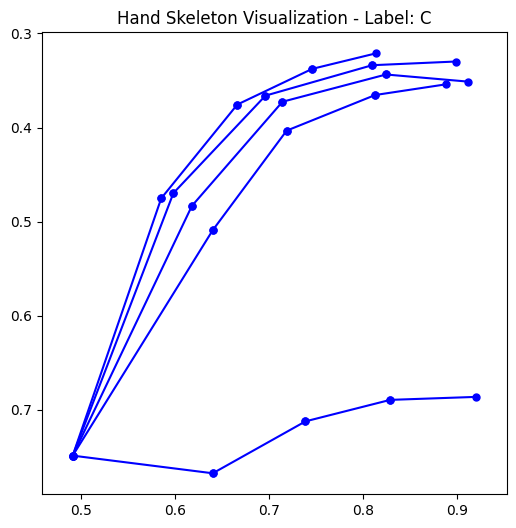

In [19]:
# Function to plot a hand skeleton from keypoint features
def plot_hand_skeleton(features, label=None):
    """
    Plots a hand skeleton based on the extracted Mediapipe keypoints.
    Expects features to be a flat list of [x1, y1, z1, x2, y2, z2, ...].
    """
    if len(features) != 63:  # 21 key points * 3 (x, y, z) each
        print("Invalid feature length.")
        return

    # Reshape into (21, 3) for 21 keypoints with x, y, z coordinates
    keypoints = [(features[i], features[i+1], features[i+2]) for i in range(0, len(features), 3)]

    # Define Mediapipe hand connections for skeleton visualization
    hand_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky finger
    ]

    # Plot each keypoint and connection
    plt.figure(figsize=(6, 6))
    for connection in hand_connections:
        x1, y1, _ = keypoints[connection[0]]
        x2, y2, _ = keypoints[connection[1]]
        plt.plot([x1, x2], [y1, y2], 'bo-', markersize=5)  # Plot as blue line with circles

    # Set plot title and axis properties
    plt.title(f"Hand Skeleton Visualization - Label: {label}")
    plt.gca().invert_yaxis()  # Invert y-axis for image-like coordinates
    plt.axis("equal")
    plt.show()

# Pick a sample row to visualize
sample_index = 500  # Change index as needed to visualize different samples
sample_features = train_df.iloc[sample_index, :-1].values  # Exclude label column
sample_label = train_df.iloc[sample_index, -1]  # Get label

# Visualize the hand skeleton for the selected sample
plot_hand_skeleton(sample_features, label=sample_label)

In [20]:
# Set the number of samples per class for testing
samples_per_class = 10
min_samples_per_class = samples_per_class * 2  # Ensure each class can be split evenly

# Filter classes with enough samples
class_counts = train_df['label'].value_counts()
sufficient_classes = class_counts[class_counts >= min_samples_per_class].index
filtered_df = train_df[train_df['label'].isin(sufficient_classes)].reset_index(drop=True)

# Separate features and labels
X = filtered_df.drop(columns=["label"]).values
y = filtered_df["label"].values

# Stratified split to ensure each class is in both train and test sets
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=(samples_per_class * len(sufficient_classes)) / len(y), random_state=42)
for train_index, test_index in strat_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [21]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           A       0.91      1.00      0.95        10
           B       1.00      1.00      1.00        10
           C       1.00      1.00      1.00        10
           D       1.00      0.90      0.95        10
           E       0.91      1.00      0.95        10
           F       1.00      1.00      1.00        10
           G       0.91      1.00      0.95        10
           H       1.00      1.00      1.00        10
           I       1.00      0.80      0.89        10
           J       1.00      1.00      1.00        10
           K       0.83      1.00      0.91        10
           L       1.00      1.00      1.00        10
           M       0.89      0.80      0.84        10
           N       0.90      0.90      0.90        10
           O       0.91      1.00      0.95        10
           P       1.00      0.90      0.95        10
           Q       0.91      1.00    

In [22]:
def plot_hand_skeleton(features, label=None, predicted_label=None):
    """
    Plots a hand skeleton based on extracted Mediapipe keypoints.
    Expects features to be a flat list of [x1, y1, z1, x2, y2, z2, ...].
    """
    if len(features) != 63:  # 21 key points * 3 (x, y, z) each
        print("Invalid feature length.")
        return

    # Reshape into (21, 3) for 21 keypoints with x, y, z coordinates
    keypoints = [(features[i], features[i+1], features[i+2]) for i in range(0, len(features), 3)]

    # Define Mediapipe hand connections for skeleton visualization
    hand_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky finger
    ]

    # Plot each keypoint and connection
    plt.figure(figsize=(6, 6))
    for connection in hand_connections:
        x1, y1, _ = keypoints[connection[0]]
        x2, y2, _ = keypoints[connection[1]]
        plt.plot([x1, x2], [y1, y2], 'bo-', markersize=5)  # Plot as blue line with circles

    # Set plot title with original and predicted labels
    plt.title(f"Original Label: {label} | Predicted Label: {predicted_label}")
    plt.gca().invert_yaxis()  # Invert y-axis for image-like coordinates
    plt.axis("equal")
    plt.show()

def predict_and_plot(features, original_label, model, label_encoder):
    """
    Predicts the sign language letter based on extracted features and plots the hand skeleton
    with the original and predicted labels.
    """
    # Reshape features to match input shape expected by the model
    features = np.array(features).reshape(1, -1)  # No additional scaling

    # DEBUG: Print features to verify consistency
    print("Sample features (pre-scaled):", features[0][:10])  # Print first 10 for brevity

    # Predict the encoded label and decode it to the original letter
    label_encoded = model.predict(features)
    predicted_label = label_encoder.inverse_transform(label_encoded)[0]

    # DEBUG: Print original vs predicted label
    print(f"Original Label: {original_label} | Predicted Label: {predicted_label}")

    # Plot hand skeleton with original and predicted labels
    plot_hand_skeleton(features.flatten(), label=original_label, predicted_label=predicted_label)

    return predicted_label

Sample features (pre-scaled): [ 1.04005067  0.37614831  0.84640041  0.85523142  0.19711723 -0.01271938
  0.30382198  0.12270015  0.09740784 -0.11865981]
Original Label: H | Predicted Label: H


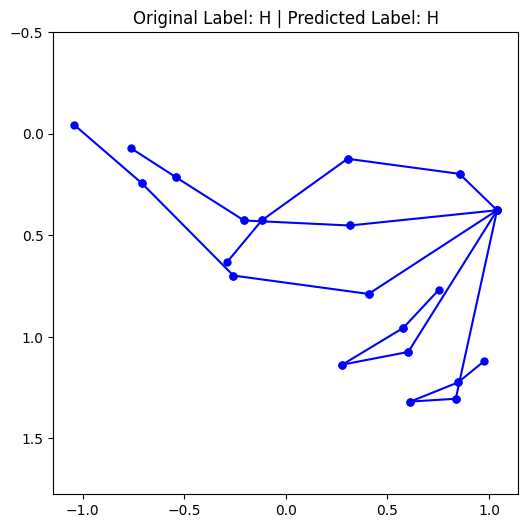

Original Label: H | Predicted Label: H


In [23]:
# Example usage
sample_index = 5  # Choose an index to visualize
original_label = label_encoder.inverse_transform([y_test[sample_index]])[0]
sample_features = X_test[sample_index]
predicted_label = predict_and_plot(sample_features, original_label, model, label_encoder)

print(f"Original Label: {original_label} | Predicted Label: {predicted_label}")

In [24]:
import pickle

# Save the model, label encoder, and scaler
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Model, label encoder, and scaler saved.")


Model, label encoder, and scaler saved.


##predictions

In [3]:
import pickle
# Load the model, label encoder, and scaler
with open("model.pkl", "rb") as f:
    model = pickle.load(f)
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
print("Model, label encoder, and scaler loaded.")


Model, label encoder, and scaler loaded.


In [7]:
import cv2
import mediapipe as mp
import numpy as np
import time

# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

def capture_continuous_words(model, label_encoder, scaler=None):
    """
    Continuously captures hand gestures, predicts letters, and builds words with "fist closed"
    confirmation, supporting 'space' and 'delete' gestures.
    """
    cap = cv2.VideoCapture(0)
    text = ""  # To store the continuous word/sentence
    last_pred = None  # To hold the last predicted symbol
    confirmation_mode = False  # Flag for "closed fist" confirmation

    print("Starting real-time hand gesture word prediction...")
    print("Show a letter symbol, then close your fist to confirm. Use 'space' for space, 'del' to delete.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image. Retrying...")
            continue

        # Convert frame to RGB and detect hands
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            # Extract landmarks
            landmarks = results.multi_hand_landmarks[0].landmark
            features = [coord for lm in landmarks for coord in (lm.x, lm.y, lm.z)]

            # Check if fist is closed for confirmation
            if is_fist_closed(landmarks):
                if confirmation_mode and last_pred:
                    # Update text based on last predicted character
                    if last_pred == "space":
                        text += " "
                    elif last_pred == "del":
                        text = text.rsplit(' ', 1)[0]  # Delete last word
                    else:
                        text += last_pred  # Add last predicted letter

                    print(f"Current Text: '{text}'")
                    confirmation_mode = False  # Reset confirmation mode
                else:
                    confirmation_mode = True  # Enter confirmation mode
                time.sleep(0.5)  # Debounce for fist confirmation
                continue  # Skip prediction if confirming

            # Preprocess and predict gesture
            features = np.array(features).reshape(1, -1)
            if scaler:
                features = scaler.transform(features)

            # Predict the label
            label_encoded = model.predict(features)
            predicted_label = label_encoder.inverse_transform(label_encoded)[0]
            last_pred = predicted_label  # Save prediction for confirmation

            # Display frame with predicted label
            frame = cv2.putText(frame, f"Predicted: {predicted_label}", (10, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            # frame = cv2.putText(frame, f"Text: {text}", (10, 100),
            #                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        else:
            # If no hand is detected, display message
            frame = cv2.putText(frame, "No hand detected", (10, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            last_pred = None  # Clear last prediction if no hand is detected

        cv2.imshow("Real-Time Hand Gesture Word Prediction", frame)

        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

def is_fist_closed(landmarks):
    """
    Determines if the hand is in a "closed fist" position based on landmarks.
    This can be defined as when the tip of each finger is close to the wrist.
    """
    thumb_tip = landmarks[4]
    index_tip = landmarks[8]
    middle_tip = landmarks[12]
    ring_tip = landmarks[16]
    pinky_tip = landmarks[20]
    wrist = landmarks[0]

    # Calculate the distance between each finger tip and the wrist
    def distance(point1, point2):
        return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2 + (point1.z - point2.z)**2)

    distances = [distance(thumb_tip, wrist), distance(index_tip, wrist),
                 distance(middle_tip, wrist), distance(ring_tip, wrist),
                 distance(pinky_tip, wrist)]

    # Return True if all fingers are close to the wrist, indicating a closed fist
    return all(d < 0.1 for d in distances)  # Adjust threshold as needed


In [8]:
capture_continuous_words(model, label_encoder, scaler)

Starting real-time hand gesture word prediction...
Show a letter symbol, then close your fist to confirm. Use 'space' for space, 'del' to delete.
